In [1]:
%pip install transformers pytorch-lightning matplotlib pandas sklearn gdown PyPDF2 pycryptodome striprtf --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast as DBTokenizerF, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, GPT2Tokenizer, GPT2ForSequenceClassification, ElectraTokenizer, ElectraForSequenceClassification
import json
import string
import re
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import classification_report
import os
from PyPDF2 import PdfReader
from bs4 import BeautifulSoup
from striprtf.striprtf import rtf_to_text
import csv
from sklearn.preprocessing import MultiLabelBinarizer

/home/simone.mattioli/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## TOXIC DATASET

In [3]:
df = pd.read_csv("toxic_comments.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
sum(df["comment_text"].str.split().apply(len) > 512) 

1979

<AxesSubplot: >

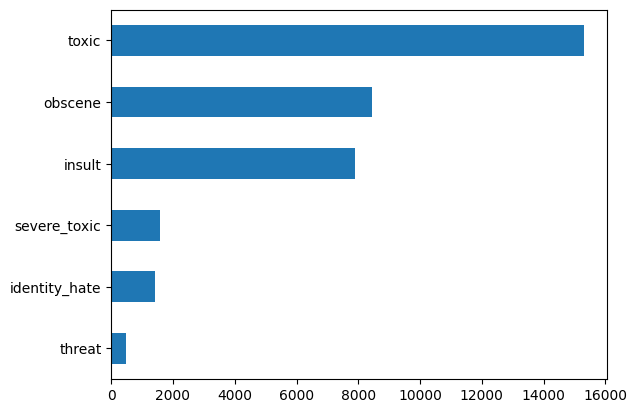

In [5]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

16225


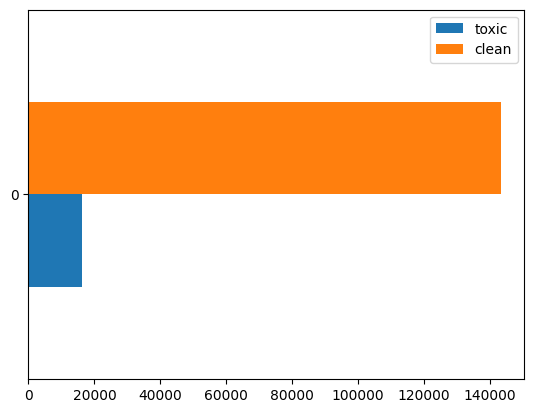

In [6]:
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  toxic=[len(df_toxic)], 
  clean=[len(df_clean)]
)).plot(kind='barh');
print(len(df_toxic))

In [7]:
df = pd.concat([
  df_toxic,
  df_clean.sample(15_000)
])

In [8]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df, val_df = train_test_split(train_df, test_size=0.1)

In [9]:
train_df.shape, val_df.shape, test_df.shape

((25291, 8), (2811, 8), (3123, 8))

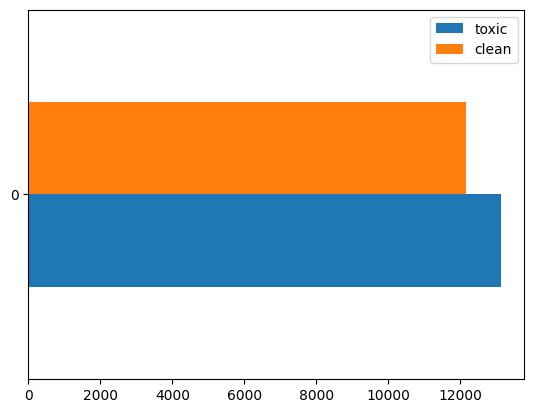

In [10]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

## DATASET MAGGIOLI 

### html, rtf, pdf to txt

In [ ]:
root = "/home/simone.mattioli/work/documenti/"
for dirpath, dirnames, filenames in os.walk(root):
    dirnames = [d for d in dirnames if not d.startswith(".")]
    filenames = [f for f in filenames if not f.startswith(".")]
    for filename in tqdm(filenames):
        fullpath = os.path.join(dirpath, filename)
        filename, extension = os.path.splitext(fullpath)
        id_file = filename.split('_')[0]
        if not extension == '.json':
            if extension == '.pdf':
                reader = PdfReader(fullpath)
                text = ""
                for page in reader.pages:
                    text += page.extract_text() + "/n"
            if extension == '.html':
                with open(fullpath, "rb") as f:
                    soup = BeautifulSoup(f)
                    text = soup.get_text()
            if extension == '.rtf':
                with open(fullpath, "r") as f:
                    text = rtf_to_text(f.read(), errors='ignore')
            
            with open(f"{id_file}_content.txt", 'w') as f:
                f.write(text)
            
        


### csv building

In [ ]:
root = "documenti/"
with open('dataset.csv','w') as f1:
    writer=csv.writer(f1)
    writer.writerow(["path", "labels"])
    for dirpath, dirnames, filenames in os.walk(root):
        dirnames = [d for d in dirnames if not d.startswith(".")]
        filenames = [f for f in filenames if not f.startswith(".")]
        for filename in filenames:
            fullpath = os.path.join(dirpath, filename)
            filename, extension = os.path.splitext(fullpath)
            id_file = filename.split('_')[0]
            if extension == '.txt':
                with open(f"{id_file}_metadata.json", "r") as metadata:
                    labels = json.load(metadata)['tags']
                    labels = ",".join(labels)        
                writer.writerow([id_file,labels])

In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
df

In [ ]:
labels = []
for l in df["labels"]:
    l = l.split(",")
    labels.append([[label] for label in l])
        

In [ ]:
labels = [l.split(",") for l in df["labels"]]

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(labels)

In [ ]:
l = mlb.transform(labels)

In [ ]:
mlb.classes_

## UTILITY

In [ ]:
class CustomDataset_csv(Dataset):

  def __init__(
    self,
    mlb,
    paths:, 
    tokenizer, 
    max_token_len: int
  ):
    self.mlb = mlb
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    self.pattern = r'[' + string.punctuation + ']'
  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index: int):
        with open(f"{self.paths[index]}_content.txt", "r") as f:
            comment_text = re.sub(self.pattern, '', f.read()).lower()
            
        with open(f"{self.paths[index]}_metadata.json", "r") as f:
            labels = json.load(f)['tags']
            labels = sum(mlb.transform([[label] for label in labels]))
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [11]:
class CustomDataset_df(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer, 
    max_token_len: int
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [12]:
class CustomDataModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_dataset = train_df
    self.val_dataset = val_df
    self.test_dataset = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = CustomDataset_df(
      self.train_dataset,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = CustomDataset_df(
      self.val_dataset,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = CustomDataset_df(
      self.test_dataset,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

In [13]:
class CustomTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=True, num_labels = 768)
    self.model.config.pad_token_id = self.model.config.eos_token_id
    self.classifier = nn.Linear(self.model.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.model(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.logits)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

## CHOOSE MODEL

In [14]:
model_choosen = "dbert"


if model_choosen == "gpt2":
    MODEL_NAME = 'gpt2'
    tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
    model = GPT2ForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=True, num_labels = 768)
    tokenizer.pad_token = tokenizer.eos_token
    MAX_TOKEN_COUNT = 1024 
if model_choosen == "dbert":
    MODEL_NAME = "distilbert-base-uncased"
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=True, num_labels = 768)
    tokenizer = DBTokenizerF.from_pretrained(MODEL_NAME)
    MAX_TOKEN_COUNT = 512 
if model_choosen == "electra_ita":
    MODEL_NAME = "dbmdz/bert-base-italian-xxl-cased"
    model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=True, num_labels = 768)
    tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)
    MAX_TOKEN_COUNT = 512 


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

## TRAIN

In [ ]:
N_EPOCHS = 1
BATCH_SIZE = 8

data_module = CustomDataModule(
  train_df,
  val_df,
  test_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

In [ ]:
model = CustomTagger(
    model,
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  enable_progress_bar=True
)

In [ ]:
trainer.fit(model, data_module)

## EVALUATE

In [15]:
trained_model = CustomTagger.load_from_checkpoint(
  "checkpoints/best-checkpoint.ckpt",
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

test_dataset = CustomDataset_df(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

100%|██████████| 3123/3123 [00:20<00:00, 152.88it/s]


In [18]:
labels

tensor([[1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [20]:
predictions.shape

torch.Size([3123, 6])

In [21]:
THRESHOLD = 0.5

lol = accuracy(predictions, labels, threshold=THRESHOLD)                                  

In [22]:
lol

tensor(0.9431)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))